<img src="https://www.gov.br/cbpf/pt-br/assuntos/noticias/titular-tem-artigo-em-periodico-de-prestigio/cbpf.png"  width="500" />

# DESGW-SPECTRO Spectrum Classifiers
This project is a collaboration to develop two spectrum classifiers using Simulation Based Inference (Deep Learning). 
- The first classifier distinguishes between Supernovas and Kilonovas
- The second classifier classifies Supernova spectra as either Type I or Type II.
## Usage:
This Jupyter notebook demonstrates how to use the SBI for classification and how to preprocess the spectra data. It serves as a guide on how to input the spectrum into the model for classification.
### Installation
To use this notebook, please ensure that you have the following libraries installed:
- PyTorch
- NumPy
- Matplotlib
- Seaborn
- SBI
To install the SBI package (https://www.mackelab.org/sbi/)


### Credits
This project was developed by Phelipe Darc  and contributors from CBPF.

- email: phelipedarc@gmail.com

### Input Data requirements: 
The codes for each preprocessing's step is displayed in appendix A.
In order to obtain accurate results, we need to ensure that the input data meets certain requirements. Here are the following steps to prepare your input data:

#### Step 1: Check the Spectrum's wavelength range

- The SEDs must be in the range of (5000 - 8000) Angstrom. Ensure that your input data meets this range requirement in order to assure the interpolation step to occur without any error. 
#### Step 2: Units of flux measurements

- The flux measurements must be in the units of erg/s/cm^2/Å and corrected to 10pc. Ensure that your input data is in this unit. If not, convert the unit to this standard unit.
#### Step 3: Reduction of Atmospheric Noise (Optional)

- In order to obtain the best results from your analysis, we highly recommend reducing atmospheric noise to achieve a smoother spectrum. The models used in this analysis were trained on simulated kilonova data without any noise, and reducing noise can help align your input data with the assumptions of the models.

#### Step 4: SEDs Interpolation

- The SEDs must have 550 points of flux, so we need to interpolate each spectrum and evaluate it in the wavelength range. Make sure to interpolate the spectrum to have exactly 550 points of flux.

#### Step 5: Flux Normalization 
- The last step is to normalize the flux of each spectrum in range of 0 - 1. 

### Input:
- The input of the SBI model is only the normalized Flux.
   

By following these steps, you will have input data that meets the requirements for accurate spectrum analysis.

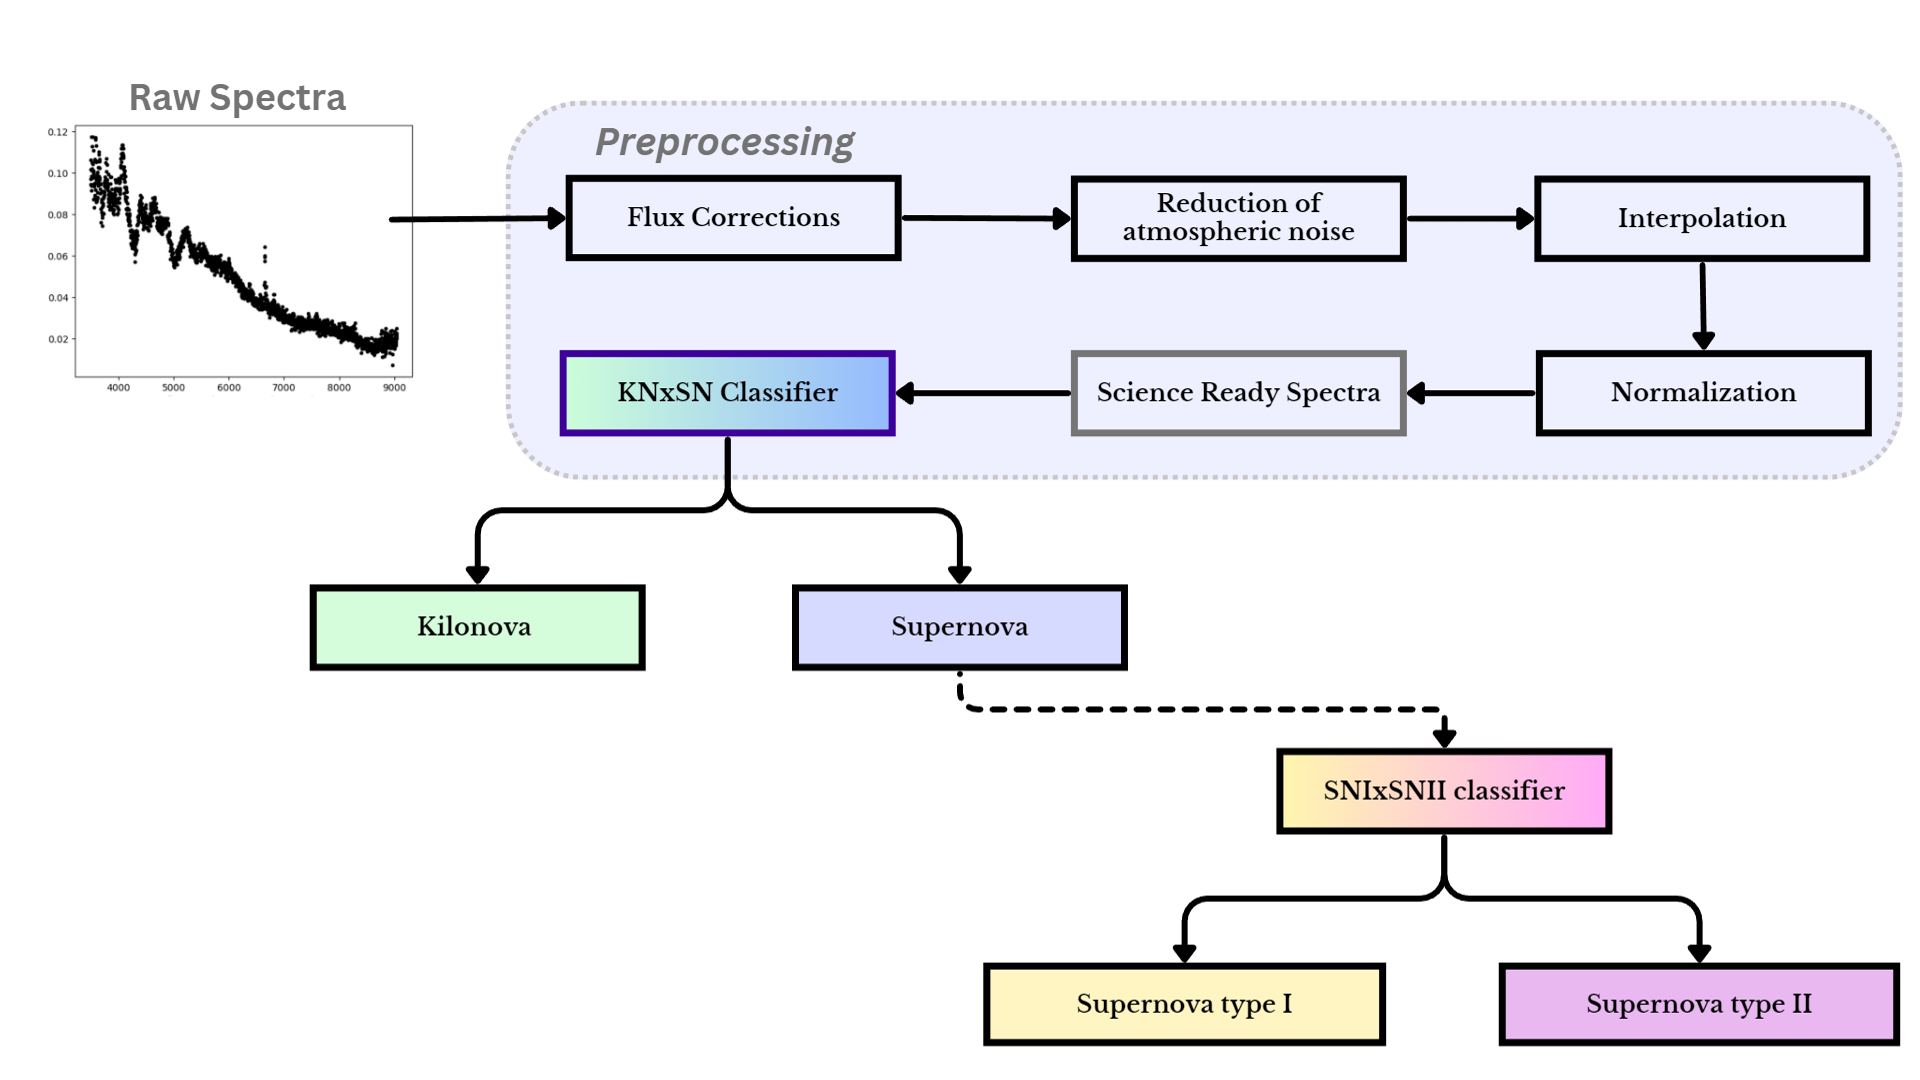

# Tutorial:

This is just a notebook tutorial exemple, you have to preprocess and import your own data. A quick introduction to the preprocessing steps is provided in the appendix.

---

In [1]:
import os, sys
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch import nn
import kilonovanet
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from scipy import stats as st
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNLE, ratio_estimator_based_potential, SNRE_A,SNRE,SNPE
from sbi.inference import likelihood_estimator_based_potential, ImportanceSamplingPosterior, MCMCPosterior
import torch
from scipy.stats import binned_statistic, linregress, gaussian_kde
import pandas as pd
import pickle
import seaborn as sns

In [2]:
idxtest = np.load('/tf/phelipedock2/Kilonovas-spec/Pytorch_notebooks/indextestSNIpipeline.npy',allow_pickle=True)
idxtest1 = np.load('/tf/phelipedock2/Kilonovas-spec/Pytorch_notebooks/indextestSNIIpipeline.npy',allow_pickle=True)
X_datasn = np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/NEWNEWSN1preprocessed.npy',allow_pickle=True)
X_datakn = np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/KNpreprocessednoise2.npy',allow_pickle=True)
X_datasn2 = np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/NEWNEWSN2preprocessed.npy',allow_pickle=True)
X_dataknreal = np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/NEWKNrealpreprocessed2nonorm.npy',allow_pickle=True)

#### Exemple of how to normalize the Input data:

In [3]:
for i in range(len(X_dataknreal)):
    mini = np.min(X_dataknreal[i][:,1])
    maxi = np.max(X_dataknreal[i][:,1])
    X_dataknreal[i][:,1] = (X_dataknreal[i][:,1]-mini)/abs(maxi-mini)

**Selecting 3 samples of each class -> KN(GW170817), SNI and SNII**

In [4]:
X_pipeline  = np.concatenate((X_datasn[idxtest][6:9],X_datasn2[idxtest1][6:9],X_dataknreal[:20][6:9]))

In [5]:
X_pipeline.shape

(9, 550, 2)

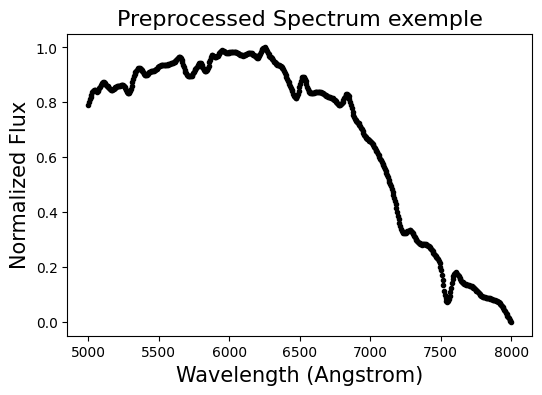

In [6]:
plt.figure(dpi=100)
plt.plot(X_pipeline[7][:,0],X_pipeline[7][:,1], 'k.')
plt.xlabel('Wavelength (Angstrom)', fontsize=15)
plt.ylabel('Normalized Flux', fontsize=15)
plt.title('Preprocessed Spectrum exemple', fontsize=16)
plt.show()

In [7]:
#input shape (N,1,550) -->  current shape (N,550,2)
X_pipeline = np.swapaxes(X_pipeline[:,:,1:2],1,2)

#### Shape of the input data

In [8]:
X_pipeline.shape

(9, 1, 550)

---
# KN x SN Classifier:
- Classifies the spectrum in KN or SN

If the most probable value of the posterior prediction is 1 then the spectrum is labeled as Kilonova, if the most probable value of the posterior prediction is 0, then it's a SN.

labels:
    
    - SN: 0
    - KN: 1
    
Note: Each binary classifier (KNxSN and SNIxSNII) are independent then It can be used in series or in parallel.

In [9]:
y_pipeline = pd.DataFrame(np.zeros((len(X_pipeline),3)), columns=['Score SNxKN','Score SNIxSNII','Final Prediction'])
#For a better understanding I'll label the lines also but each SED must have an ID associated
y_pipeline['SED'] = ['SNI','SNI','SNI','SNII','SNII','SNII','KN','KN','KN']

In [11]:
#importing the first model
import torch
import torch.nn as nn
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
       
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.act1 = nn.SELU()
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
       
        self.lstm = nn.LSTM(input_size=90, hidden_size=1200, bidirectional=True, batch_first=True)
        #GlobalMaxPooling + Flatten --- aqui:
        self.global_pool = nn.Flatten()
        self.fc1 = nn.Linear(in_features=307200, out_features=100)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=50)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
       
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
       
        x, _ = self.lstm(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
      
        return x

In [12]:
#READING THE KNxSN MODEL
with open("/tf/phelipedock2/Kilonovas-spec/Pytorch_notebooks/sbi-logs/KNxSN-Copy1.pkl", "rb") as z:
    f = pickle.load(z)

The SBI model outputs the posterior distribution, which can be interpreted as the ""probability"" distribution of the input spectrum belonging to a kilonova (KN).

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


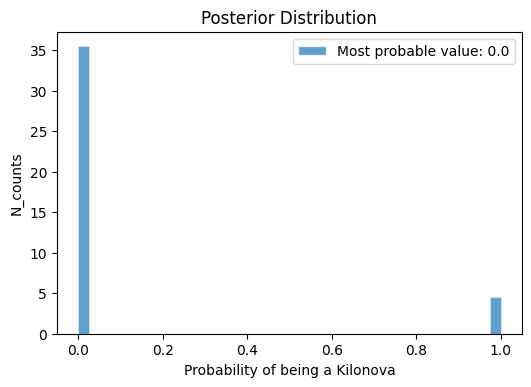

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


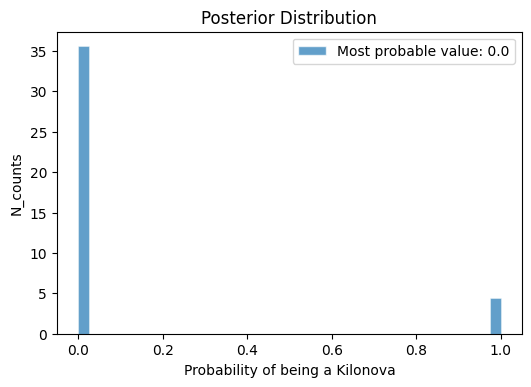

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


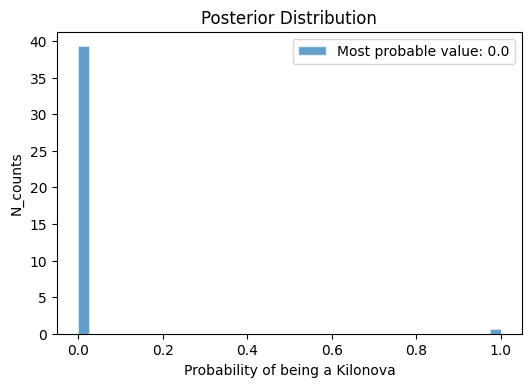

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


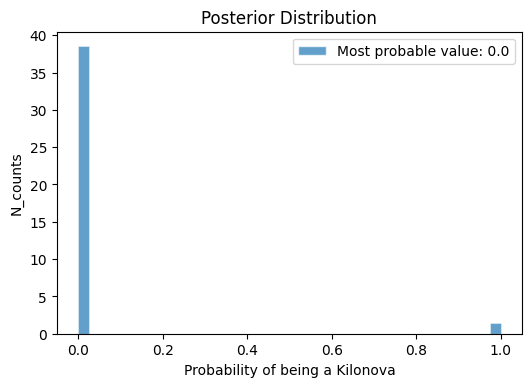

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


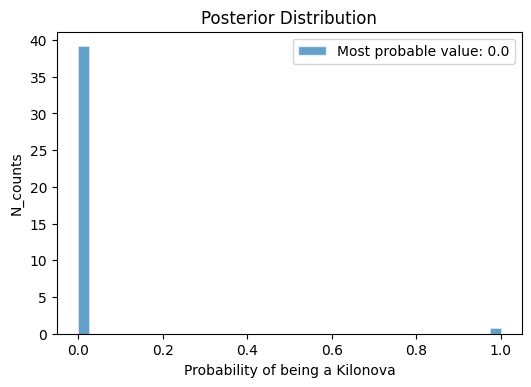

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


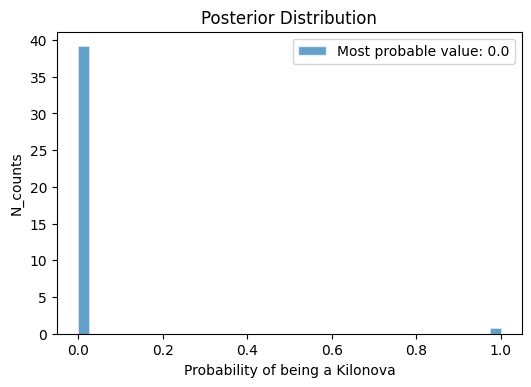

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


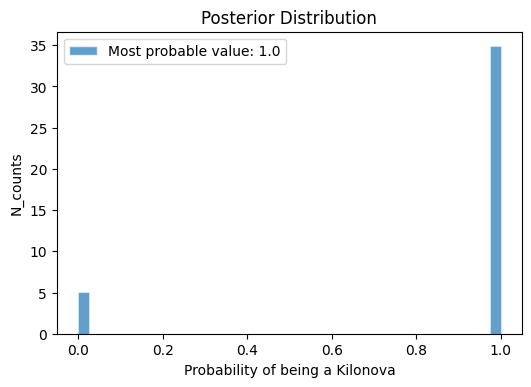

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


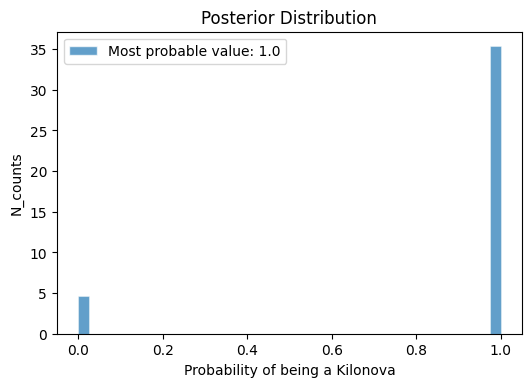

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


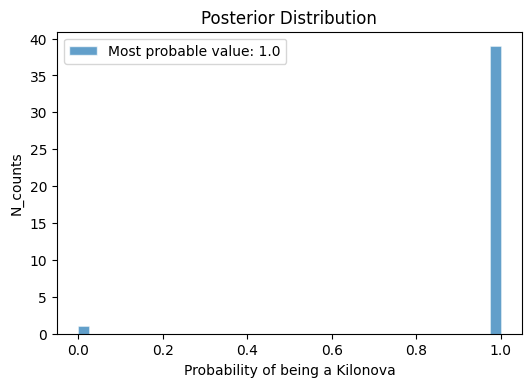

In [18]:
y_pred = []
for i in range(len(X_pipeline)):
    samples = f.sample((5000,), x = torch.as_tensor(X_pipeline[i:i+1]).to('cuda'),show_progress_bars=False).cpu().numpy()
    # Find the most probable value
    samples = np.floor(samples)
    kdec = gaussian_kde(samples[:,0])
    support = np.linspace(np.min(samples),np.max(samples), 1000)
    yc = kdec(support)
    value = support[np.argmax(yc)]
    y_pred.append(value)
    plt.figure(dpi=100)
    ax = sns.histplot(samples, kde=False,stat="density", kde_kws=dict(cut=3),alpha=.7, edgecolor=(1, 1, 1, .4),bins=40)
    ax.set(ylabel='N_counts', xlabel='Probability of being a Kilonova')
    ax.set_title('Posterior Distribution')
    ax.legend(['Most probable value: '+str(np.round(value,3))])
    plt.show()
y_pred=np.array(y_pred)

In [19]:
y_pipeline['Score SNxKN'] = y_pred

---
# SNI x SNII Classifier
If the most probable value of the posterior prediction is 1 then the spectrum is labeled as Supernova type I, if the most probable value of the posterior prediction is equal to 0, then it's a SN type II.
    
    - SNI:  1
    - SNII: 0

In [20]:
import torch
import torch.nn as nn

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__() 
        self.conv10 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.act1 = nn.SELU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
       
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=2)
        self.conv23 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=2)
        self.act2 = nn.SELU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
       
        self.lstm = nn.LSTM(input_size=135, hidden_size=1200, bidirectional=True, batch_first=True)
       
        self.global_pool = nn.Flatten()
        self.fc1 = nn.Linear(in_features=307200, out_features=100)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=30)
        

    def forward(self, x):
        x = self.conv10(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
      
        x = self.conv2(x)
        x = self.conv23(x)
        x = self.act2(x)
        x = self.pool2(x)
      
        x, _ = self.lstm(x)
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
       
        return x

In [21]:
#READING THE SNIxSNII MODEL
with open("/tf/phelipedock2/Kilonovas-spec/Pytorch_notebooks/sbi-logs/SNIxSNII-Copy1.pkl", "rb") as z:
    z = pickle.load(z)

In [22]:
mask = y_pipeline['Score SNxKN']<1

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


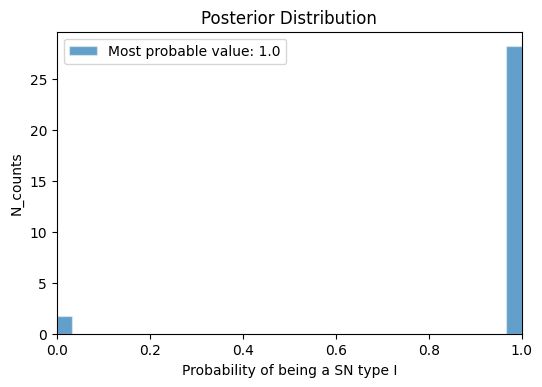

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


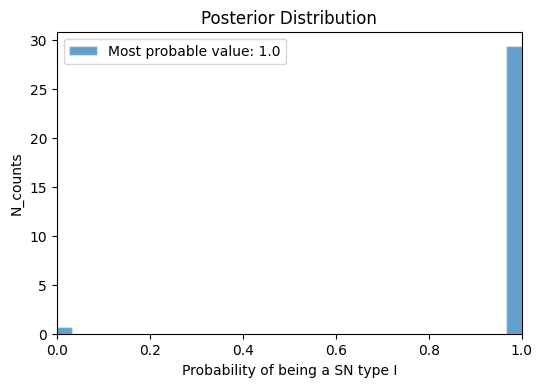

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


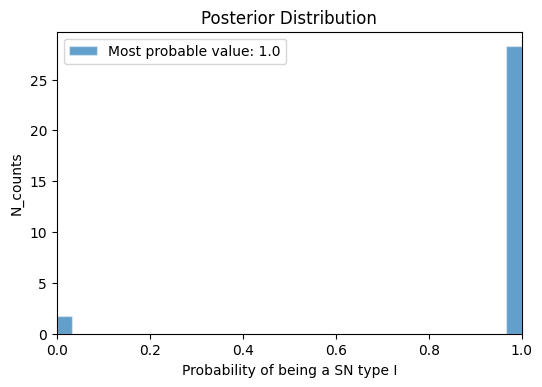

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


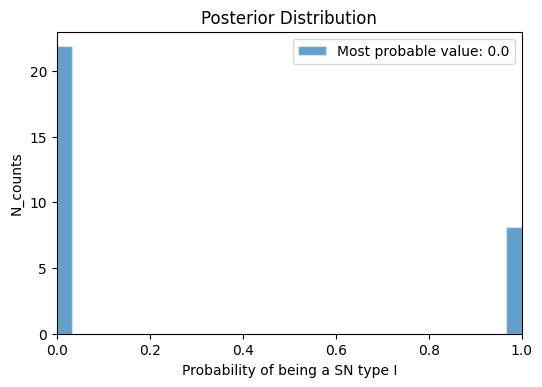

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


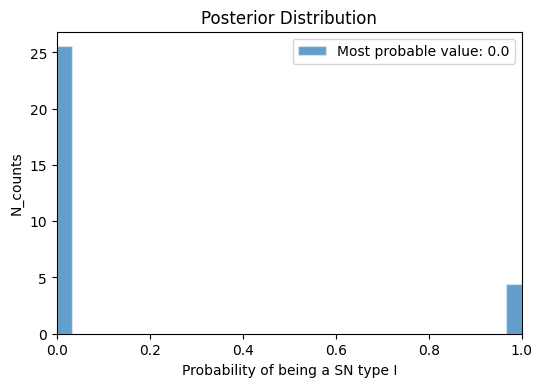

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


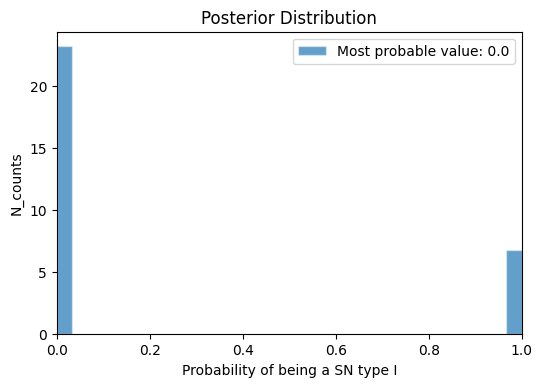

In [26]:
y_pred2 = []
for i in range(len(X_pipeline[mask])):
    samples = z.sample((2000,), x = torch.as_tensor(X_pipeline[mask][i:i+1]).to('cuda'),show_progress_bars=False).cpu().numpy()
    samples=np.floor(samples)
    # Find the most probable value
    kdec = gaussian_kde(samples[:,0])
    support = np.linspace(np.min(samples),np.max(samples), 1000)
    yc = kdec(support)
    value = support[np.argmax(yc)]
    y_pred2.append(value)
    #Histogram
    plt.figure(dpi=100)
    ax = sns.histplot(samples, kde=False,stat="density", kde_kws=dict(cut=3),alpha=.7, edgecolor=(1, 1, 1, .4),bins=30,color='orange')
    ax.set(ylabel='N_counts', xlabel='Probability of being a SN type I')
    ax.set_title('Posterior Distribution')
    ax.set_xlim((0,1))
    ax.legend(['Most probable value: '+str(np.round(value,3))])
    plt.show()
    
y_pred2=np.array(y_pred2)

In [27]:
y_pipeline['Score SNIxSNII'][mask] = y_pred2

/tmp/ipykernel_128/2012305834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pipeline['Score SNIxSNII'][mask] = y_pred2


In [37]:
for i in range(len(y_pipeline)):
    if y_pipeline['Score SNxKN'][i]==0 and y_pipeline['Score SNIxSNII'][i]==1:
        y_pipeline['Final Prediction'][i] = 'SNI'
    if y_pipeline['Score SNxKN'][i]==0 and y_pipeline['Score SNIxSNII'][i]==0:
            y_pipeline['Final Prediction'][i] = 'SNII'
    if y_pipeline['Score SNxKN'][i]==1:
        y_pipeline['Final Prediction'][i] = 'KN'

In [38]:
y_pipeline

,Score SNxKN,Score SNIxSNII,Final Prediction,SED
0,0.0,1.0,SNI,SNI
1,0.0,1.0,SNI,SNI
2,0.0,1.0,SNI,SNI
3,0.0,0.0,SNII,SNII
4,0.0,0.0,SNII,SNII
5,0.0,0.0,SNII,SNII
6,1.0,0.0,KN,KN
7,1.0,0.0,KN,KN
8,1.0,0.0,KN,KN


# Appendix -  Preprocessing Stage

In [27]:
#Importing a Raw sed
test = np.load("/tf/phelipedock2/Kilonovas-spec/RawtutorialSEDSNI.npy")
test.shape

(6389, 2)

## Raw SED

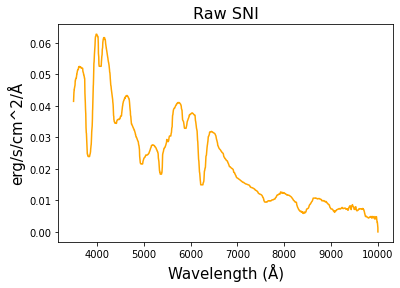

In [99]:
plt.plot(test[:,0],test[:,1], 'orange')
plt.xlabel('Wavelength (Å)', fontsize=15)
plt.ylabel('erg/s/cm^2/Å', fontsize=15)
plt.title('Raw SNI', fontsize=16)
plt.show()

## Flux corrections:
Luminosity distance = 86.67 Mpc

$F_{10pc} = F_{Obs} * \left(\frac{lumdist}{10pc}\right)^2$

In [33]:
test[:,1] = test[:,1]*(((86.67*10**6)/10)**2)

## Noise Attenuation

In [35]:
from scipy import signal
import scipy

In [57]:
#This value depends on the SED you are dealing, choose the optimal value
step = 93

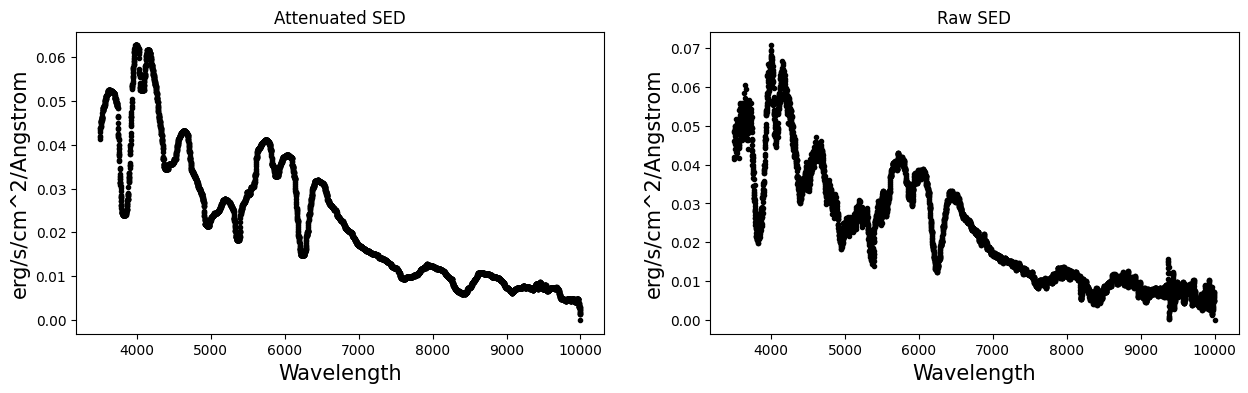

In [58]:
signal_detrend = scipy.signal.medfilt(test[:,1],step)
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,4),dpi=100) 
ax1.plot(test[:,0],signal_detrend, 'k.')
ax2.plot(test[:,0],test[:,1], 'k.')
ax1.set_xlabel('Wavelength (Å)', fontsize=15)
ax1.set_ylabel(r'erg/s/cm^2/Å', fontsize=15)
ax1.set_title('Attenuated SED')
ax2.set_xlabel('Wavelength (Å)', fontsize=15)
ax2.set_ylabel(r'erg/s/cm^2/Å', fontsize=15)
ax2.set_title('Raw SED')
plt.show()

In [60]:
test[:,1] = scipy.signal.medfilt(test[:,1],93)

## Interpolation

In [54]:
from scipy.interpolate import interp1d

In [65]:
imgfinal=np.zeros((550,2))
f5 = interp1d(test[:,0],test[:,1], kind='nearest')
x11 = np.linspace(5000, 8000, 550 ,endpoint=True)
imgfinal[:,1]=f5(x11)
imgfinal[:,0]=x11

In [66]:
imgfinal.shape

(550, 2)

## Normalization

In [67]:
mini = np.min(imgfinal[:,1])
maxi = np.max(imgfinal[:,1])
imgfinal[:,1] = (imgfinal[:,1]-mini)/abs(maxi-mini)

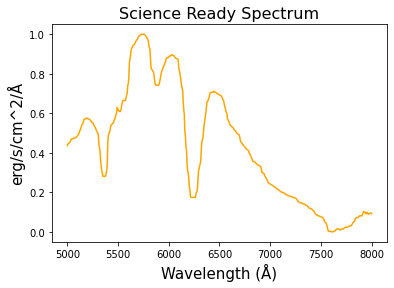

In [100]:
plt.plot(imgfinal[:,0],imgfinal[:,1], 'orange')
plt.xlabel('Wavelength (Å)', fontsize=15)
plt.ylabel('erg/s/cm^2/Å', fontsize=15)
plt.title('Science Ready Spectrum', fontsize=16)
plt.show()